In [2]:
'''
#Gigacow-tools# - data collection for good/bad memory.
This scripts used for single cow data collection work.
Data Tables: gigacow_filter.csv, lactation_filter.csv, traffic_raw_filter.csv
'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


#access data from local directory
dataDir = Path.cwd().parent.parent.parent/'Data/processed'
gigacow_cols = ['Gigacow_Cow_Id', 'FarmName_Pseudo', 'BreedName', 'BirthDate']
lactation_cols = ['Gigacow_Cow_Id', 'FarmName_Pseudo', 'LactationInfoDate', 'LactationNumber', 'DaysInMilk']
gigacow = pd.read_csv(dataDir/'gigacow_filter.csv', encoding='utf-8', usecols=gigacow_cols)
lactation = pd.read_csv(dataDir/'lactation_filter.csv', encoding='utf-8', usecols=lactation_cols)
traffic = pd.read_csv(dataDir/'traffic_raw_filter.csv', encoding='utf-8', index_col=False)
#check out cows with most milking events
print(traffic.Gigacow_Cow_Id.value_counts().nlargest(10))

5613    11903
6197    11250
4478    11054
3757    10907
2423    10864
3147    10083
4504    10016
5147     9758
3121     9518
5046     9390
Name: Gigacow_Cow_Id, dtype: int64


In [3]:
# Select cows with sufficient data points on single lactation periods
# Try to collect cow's data that contain milking events on lactation periods 1
# fetch all milking traffic events for merging
traffic_milking = traffic.TrafficResult.str.contains('kg', regex=False)
all_list = traffic_milking.index[traffic_milking.values == True].tolist()
milking_total = traffic[traffic.index.isin(all_list)]
milking_total.TrafficEventDateTime = pd.to_datetime(milking_total.TrafficEventDateTime)
milking_total['milking_date'] = milking_total.TrafficEventDateTime.dt.date

# convert data type
milking_total.milking_date = pd.to_datetime(milking_total.milking_date)
lactation.LactationInfoDate = pd.to_datetime(lactation.LactationInfoDate)
# merge all milking events with lactation table for filtering
milking_total = milking_total.merge(lactation, how='left', left_on=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'milking_date'], right_on=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'LactationInfoDate'])

def lac_collect(NumLac, milking_total):
    """Generate dataset with config.

    Args:
        NumLac: The number of lactaion period
        milking_total: A dataframe contains all the milkings events

    Returns:
        A list contain all the cows events with sufficient data points within the lactation periods.
    """
    cow_list = list()
    for num in range(1, NumLac+1):
        # select records that contains lactation period 1
        milking_select1 = milking_total.loc[milking_total['LactationNumber'] == num]
        milking_select1.drop_duplicates(subset=['Gigacow_Cow_Id', 'milking_date', 'LactationNumber', 'DaysInMilk'], inplace=True)
        # drop the anomaly data point
        milking_select1 = milking_select1.loc[milking_select1.DaysInMilk < 400]
        # select sufficient data points on lactation 1
        selected1 = milking_select1.Gigacow_Cow_Id.value_counts(ascending=True)
        selected1 = selected1.loc[(selected1.values > 100) & (selected1.values < 400)]
        selected_cow_list = selected1.index.to_list()
        if num == 1:
            cow_list = selected_cow_list
        cow_list = list(set(cow_list) & set(selected_cow_list))
        print(len(cow_list), cow_list)
    return cow_list

cow_list = lac_collect(2, milking_total)

C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_29308\2494231049.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  milking_total.TrafficEventDateTime = pd.to_datetime(milking_total.TrafficEventDateTime)
C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_29308\2494231049.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  milking_total['milking_date'] = milking_total.TrafficEventDateTime.dt.date
C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_29308\2494231049.py:11: SettingWithCopyWarning: 
A value is trying 

60 [769, 1796, 3718, 3207, 5767, 2569, 2702, 1555, 151, 5147, 2844, 1181, 3613, 926, 2423, 2979, 5160, 4008, 4525, 943, 3762, 5301, 182, 5046, 702, 3447, 1985, 708, 2374, 6086, 4038, 6472, 3657, 5322, 1738, 74, 5965, 2510, 1103, 4176, 4311, 985, 5465, 5852, 478, 1247, 5088, 6241, 5092, 2278, 6380, 5616, 1905, 5235, 4341, 2039, 3705, 3707, 4990, 2047]
13 [478, 3718, 2569, 74, 6380, 1103, 1555, 182, 5046, 5147, 1181, 926, 2423]


C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_29308\2494231049.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  milking_select1.drop_duplicates(subset=['Gigacow_Cow_Id', 'milking_date', 'LactationNumber', 'DaysInMilk'], inplace=True)
C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_29308\2494231049.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  milking_select1.drop_duplicates(subset=['Gigacow_Cow_Id', 'milking_date', 'LactationNumber', 'DaysInMilk'], inplace=True)


In [4]:
def countCowAge(birthDate, milkingDate):
    '''Calculate cows age based on birthDate and milkingDate

    Args: 
        birthDate: cow's birth datetime
        milkingDate: milking events datetime

    Returns: 
        age: cow age in human years(float)
    '''
    birthDate = pd.to_datetime(birthDate)
    milkingDate = pd.to_datetime(milkingDate)
    days = np.float32(np.datetime64(milkingDate, 'D') - np.datetime64(birthDate, 'D'))
    age = np.around(days/365, 2)
    return age


def data_collector(traffic, gigacow, lactation, cow_id):

    '''select single cow from the traffic table

    Args:
        traffic: traffic data table
        gigacow: gigacow data table
        lactation: lactation data table
        cow_id: ID of cow

    Returns:
        single_cow_merge: A dataframe contains all relevant features for a single cow
    
    '''

    # Extract Milking Event and its most recent traffic event to calculate T2-T1
    # T1: Entry time into the Mjolkfalla
    # T2: Entry time into the milking robot
    # T2-T1: calculate time difference between T2&T1 (i.e., Time spend in Mjolkfalla/holding area)
    
    traffic_single_cow = traffic.loc[traffic['Gigacow_Cow_Id'] == cow_id]
    traffic_single_cow.sort_values(by='TrafficEventDateTime', inplace=True)
    traffic_single_cow.index = range(len(traffic_single_cow))

    # locate mikling event by searching 'kg' keyword in traffic result
    # the most recent traffic event to milking event should be pre_milking event
    # need to filter out records with gate failure
    track_milking = traffic_single_cow.TrafficResult.str.contains('kg', regex=False)
    milking_index_list = track_milking.index[track_milking.values == True].tolist()
    pre_milking_index_list = [x-1 for x in milking_index_list]
    milking_traffic = traffic_single_cow[traffic_single_cow.index.isin(milking_index_list)]
    pre_milking_traffic = traffic_single_cow[traffic_single_cow.index.isin(pre_milking_index_list)]

    # drop rows that the gate failed to detect cows but have milking result
    # previous area in milking_traffic table should only be Mjolkfalla
    # previous area in pre_milking_traffic table should not be Mjolkfalla
    failed_list_1_milk = milking_traffic.index[milking_traffic['PreviousArea'] == 'Koridor till Sorteringsgrind 2'].tolist()
    failed_list_1_pre = [x-1 for x in failed_list_1_milk]
    failed_list_2_pre = pre_milking_traffic.index[pre_milking_traffic['PreviousArea'] == 'Mjolkfalla'].tolist()
    failed_list_2_milk = [x+1 for x in failed_list_2_pre]
    # traffic result in pre_milking_traffic table should contain Mjolkfalla
    track_pre_milking = pre_milking_traffic.TrafficResult.str.contains('Mjolkfalla', regex=False)
    failed_list_3_pre = track_pre_milking.index[track_pre_milking.values == False].tolist()
    failed_list_3_milk = [x+1 for x in failed_list_3_pre]

    # remove failed records based on index list
    milking_traffic_failed = failed_list_1_milk + failed_list_2_milk + failed_list_3_milk
    pre_milking_traffic_failed = failed_list_1_pre + failed_list_2_pre + failed_list_3_pre
    milking_traffic.drop(axis=0, index=milking_traffic_failed, inplace=True)
    pre_milking_traffic.drop(axis=0, index=pre_milking_traffic_failed, inplace=True)
    # concatenate two tables to track the traffic directly
    all_milking_traffic = pd.concat([milking_traffic, pre_milking_traffic])
    all_milking_traffic.sort_values(by=['TrafficEventDateTime'], inplace=True)
    #rename table columns for merging
    milking_traffic.rename(columns={"TrafficEventDateTime": "MilkingEventDateTime", "TrafficResult": "MilkProduction", "TimeInArea_totalSeconds": "RoundedSecondsTimeInArea"}, inplace=True)
    pre_milking_traffic.rename(columns={"TrafficEventDateTime": "Pre_MilkingEventDateTime", "TimeInArea_totalSeconds": "RoundedSecondsTimeInArea"}, inplace=True)
    # unify the index of two tables
    milking_traffic.index = range(len(milking_traffic))
    pre_milking_traffic.index = range(len(pre_milking_traffic))
    # inert "pre_traffic_milking" to milking traffic table
    milking_traffic.insert(5, 'Pre_MilkingEventDateTime', pre_milking_traffic['Pre_MilkingEventDateTime'])
    # calculate T2-T1
    milking_traffic.MilkingEventDateTime = pd.to_datetime(milking_traffic.MilkingEventDateTime)
    milking_traffic.Pre_MilkingEventDateTime = pd.to_datetime(milking_traffic.Pre_MilkingEventDateTime)
    milking_traffic['timeDelta_Seconds'] = (milking_traffic['MilkingEventDateTime'] - milking_traffic['Pre_MilkingEventDateTime']).dt.total_seconds()

    #extract traffic result(milk production)
    milking_traffic['MilkProduction'].replace(r"[^0-9.,]+"," ", inplace=True, regex=True)
    milking_traffic['MilkProduction'].replace(r"\s*","", inplace=True, regex=True)
    milking_traffic['MilkProduction'].replace(r"[,]+",".", inplace=True, regex=True)
    milking_traffic['MilkProduction'] = milking_traffic['MilkProduction'].astype('float64')

    # merge all the other features into milking_traffic table
    milking_traffic['MilkingDate'] = milking_traffic.MilkingEventDateTime.dt.date
    milking_traffic.MilkingDate = pd.to_datetime(milking_traffic.MilkingDate)
    lactation.LactationInfoDate = pd.to_datetime(lactation.LactationInfoDate)
    single_cow_merge = milking_traffic.merge(lactation, how='left', left_on=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'MilkingDate'], right_on=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'LactationInfoDate'])
    single_cow_merge = single_cow_merge.merge(gigacow, how='left', left_on=['FarmName_Pseudo', 'Gigacow_Cow_Id'], right_on=['FarmName_Pseudo', 'Gigacow_Cow_Id'])

    # drop failed data points based on RoundedSecondsTimeInArea & timeDelta_Seconds
    single_cow_merge.drop(single_cow_merge.loc[abs(single_cow_merge.timeDelta_Seconds - single_cow_merge.RoundedSecondsTimeInArea) > 300].index, inplace=True)
    single_cow_merge['TrafficDeviceName'].replace(r"[A-Za-z]+\s*","vms", inplace=True, regex=True)
    # calculate age of cows
    single_cow_merge['Age'] = single_cow_merge.apply(lambda x: countCowAge(x['BirthDate'], x['MilkingEventDateTime']), axis=1)
    single_cow_merge.drop(['BirthDate'], axis=1, inplace=True)
    # single_cow_merge = single_cow_merge.loc[single_cow_merge.LactationNumber == 1]

    return single_cow_merge

C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_29308\812139334.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traffic_single_cow.sort_values(by='TrafficEventDateTime', inplace=True)
C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_29308\812139334.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  milking_traffic.drop(axis=0, index=milking_traffic_failed, inplace=True)
C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_29308\812139334.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

<Figure size 432x288 with 0 Axes>

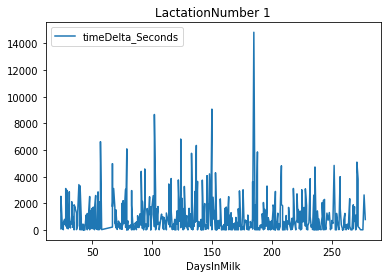

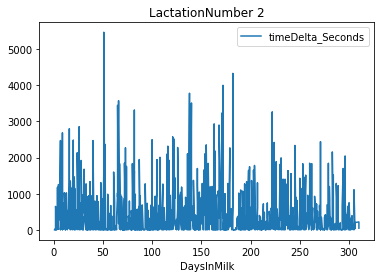

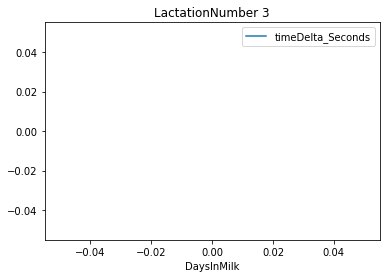

In [5]:
# plot the relations between timeDielta and Lactation/DIM(DaysInMilk)
periods = [1, 2]
single_cow_merge = data_collector(traffic, gigacow, lactation, 6380)
single_cow_merge = single_cow_merge.loc[single_cow_merge.LactationNumber.isin(periods)]
plt.figure()
single_cow_merge.loc[single_cow_merge.LactationNumber == 1].plot(x="DaysInMilk", y="timeDelta_Seconds", kind='line', title='LactationNumber 1')
single_cow_merge.loc[single_cow_merge.LactationNumber == 2].plot(x="DaysInMilk", y="timeDelta_Seconds", kind='line', title='LactationNumber 2')
single_cow_merge.loc[single_cow_merge.LactationNumber == 3].plot(x="DaysInMilk", y="timeDelta_Seconds", kind='line', title='LactationNumber 3')
plt.show()


In [10]:
single_cow_merge
# single_cow_merge.loc[single_cow_merge.LactationNumber == 1].to_csv()

,Traffic_Id,FarmName_Pseudo,Gigacow_Cow_Id,GroupName,MilkingEventDateTime,Pre_MilkingEventDateTime,PreviousArea,RoundedSecondsTimeInArea,TrafficDeviceName,MilkProduction,MilkingInterval_totalSeconds,timeDelta_Seconds,MilkingDate,LactationInfoDate,LactationNumber,DaysInMilk,BreedName,Age
0,4131993,a624fb9a,6380,VMS 1,2020-10-08 06:30:50,2020-10-08 06:29:23,Mjolkfalla,60,vms2,15.91,43920.0,87.0,2020-10-08,2020-10-08,1,24.0,1,2.06
1,6273180,a624fb9a,6380,VMS 1,2020-10-08 17:51:10,2020-10-08 17:31:18,Mjolkfalla,1140,vms1,9.61,40140.0,1192.0,2020-10-08,2020-10-08,1,24.0,1,2.06
2,10420199,a624fb9a,6380,VMS 1,2020-10-08 18:53:09,2020-10-08 18:11:01,Mjolkfalla,2520,vms2,5.14,2880.0,2528.0,2020-10-08,2020-10-08,1,24.0,1,2.06
3,1197987,a624fb9a,6380,VMS 1,2020-10-09 06:43:31,2020-10-09 06:33:09,Mjolkfalla,600,vms1,15.49,41700.0,622.0,2020-10-09,2020-10-09,1,25.0,1,2.06
4,9207985,a624fb9a,6380,VMS 1,2020-10-09 18:45:58,2020-10-09 18:43:20,Mjolkfalla,120,vms1,5.69,42720.0,158.0,2020-10-09,2020-10-09,1,25.0,1,2.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1447,1294308,a624fb9a,6380,VMS 1,2022-06-11 18:52:15,2022-06-11 18:33:41,Mjolkfalla,1080,vms1,10.26,39360.0,1114.0,2022-06-11,2022-06-11,2,305.0,1,3.73
1448,10346045,a624fb9a,6380,VMS 1,2022-06-12 07:28:46,2022-06-12 07:28:08,Mjolkfalla,0,vms1,10.67,45000.0,38.0,2022-06-12,2022-06-12,2,306.0,1,3.74
1449,7835555,a624fb9a,6380,VMS 1,2022-06-12 18:00:57,2022-06-12 17:57:29,Mjolkfalla,180,vms1,9.41,37500.0,208.0,2022-06-12,2022-06-12,2,306.0,1,3.74
1450,3534375,a624fb9a,6380,"Sinkor, stallet",2022-06-16 08:31:32,2022-06-16 08:27:47,Mjolkfalla,180,vms1,15.58,NaN,225.0,2022-06-16,2022-06-16,2,310.0,1,3.75


In [16]:
pd.options.mode.chained_assignment = None

# fetch enough data points from lactation period 1&2
periods = [1, 2]
mean_totalTimeCost_1 = 0
mean_totalTimeCost_2 = 0
Path(dataDir/'memory_targetCows').mkdir(parents=True, exist_ok=True)
for p in periods:
    Path(dataDir/'memory_targetCows'/str(p)).mkdir(parents=True, exist_ok=True)

# save target cows tables to directory
for i, cow_id in enumerate(cow_list):
    single_cow_merge = data_collector(traffic, gigacow, lactation, cow_id)
    single_cow_merge = single_cow_merge.loc[single_cow_merge.LactationNumber.isin(periods)]
    single_cow_merge.sort_values(by="MilkingEventDateTime", inplace=True)
    timecost_1 = single_cow_merge.loc[single_cow_merge.LactationNumber == 1].timeDelta_Seconds.mean()
    timecost_2 = single_cow_merge.loc[single_cow_merge.LactationNumber == 2].timeDelta_Seconds.mean()
    # calculate the timecost reduction percentage
    mean_totalTimeCost_1 += timecost_1
    mean_totalTimeCost_2 += timecost_2
    print("cow_" + str(cow_id))
    print(timecost_1)
    print(timecost_2)
    diff = (timecost_1-timecost_2)/timecost_1
    print(diff)
    # threshold setting to obtain balanced dataset
    # label the data (1: good memory, 0: bad memory)
    # for threshold=40%, 13 positive samples, 9 negative samples 
    if(diff > 0.4):
        print("good")
        single_cow_merge["label"] = 1
    else:
        single_cow_merge["label"] = 0
    single_cow_merge["id"] = i+1
    single_cow_merge.dropna(inplace=True)
    for p in periods:    
        fileName = 'memory_targetCows/' + str(p) + '/cow_' + str(i) + '.csv'
        single_cow_merge.loc[single_cow_merge.LactationNumber == p].to_csv(dataDir/fileName)
print("num of cows: ", len(cow_list))
print("Mean of total time cost at lactation period 1: ", mean_totalTimeCost_1/len(cow_list))
print("Mean of total time cost at lactation period 2: ", mean_totalTimeCost_2/len(cow_list))

cow_478
1077.248492159228
414.26153846153846
0.6154447729778706
good
cow_3718
827.3369330453563
453.1363636363636
0.4522952553702546
good
cow_2569
322.80102040816325
258.60021905805036
0.1988866121579625
cow_74
672.2919418758256
383.1441307578009
0.430092632541818
good
cow_6380
925.4119850187266
459.36165577342047
0.5036138895865663
good
cow_1103
602.2002032520326
365.8
0.3925608161130003
cow_1555
799.4668989547039
465.64148816234496
0.41756001559143074
good
cow_182
1214.774193548387
754.4289439374185
0.3789554075612095
cow_5046
762.938440492476
361.2729145211122
0.5264717369753831
good
cow_5147
653.2017220172202
303.9646910466583
0.5346541798635293
good
cow_1181
1462.5687984496124
755.6945564516129
0.4833100793257161
good
cow_926
933.9160104986877
529.891823899371
0.43261297810236476
good
cow_2423
1158.8651832460732
520.1778618732261
0.5511316852093471
good
num of cows:  13
Mean of total time cost at lactation period 1:  877.9247556128071
Mean of total time cost at lactation period 2: